In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/modelsave/'

#IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagewoof2'

IMAGENETTEPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagenette2'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("torch version:", torch.__version__)
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch version: 1.7.0+cu101
check device: Tesla P100-PCIE-16GB
how many?: 1
so can i use it? True


In [ ]:
# transformation for CIFAR 10
# yet to implement standard color augmentation

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224, padding=28),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),         
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [ ]:
from google.colab import output
!mkdir "./train"
!mkdir "./val"
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/train.zip" "train.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/imagenette2/val.zip" "val.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "train.zip" -d "./train/"
!unzip "val.zip" -d "./val/"

Streaming output truncated to the last 5000 lines.
  inflating: ./train/n03445777/n03445777_8446.JPEG  
  inflating: ./train/n03445777/n03445777_8448.JPEG  
  inflating: ./train/n03445777/n03445777_8474.JPEG  
  inflating: ./train/n03445777/n03445777_8477.JPEG  
  inflating: ./train/n03445777/n03445777_8484.JPEG  
  inflating: ./train/n03445777/n03445777_8544.JPEG  
  inflating: ./train/n03445777/n03445777_8546.JPEG  
  inflating: ./train/n03445777/n03445777_8599.JPEG  
  inflating: ./train/n03445777/n03445777_8616.JPEG  
  inflating: ./train/n03445777/n03445777_8624.JPEG  
  inflating: ./train/n03445777/n03445777_8628.JPEG  
  inflating: ./train/n03445777/n03445777_866.JPEG  
  inflating: ./train/n03445777/n03445777_8663.JPEG  
  inflating: ./train/n03445777/n03445777_8677.JPEG  
  inflating: ./train/n03445777/n03445777_8678.JPEG  
  inflating: ./train/n03445777/n03445777_8679.JPEG  
  inflating: ./train/n03445777/n03445777_8683.JPEG  
  inflating: ./train/n03445777/n03445777_8694.JPE

In [ ]:
train_set = torchvision.datasets.ImageFolder(root='./train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root='./val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')

train_loader 296
test_loader 123


In [ ]:
"""train_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')"""

"train_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/train', transform=train_transform)\ntest_set = torchvision.datasets.ImageFolder(root=IMAGENETTEPATH+'/val', transform=test_transform)\ntrain_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)\ntest_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)\n\nprint(f'train_loader {len(train_loader)}')\nprint(f'test_loader {len(test_loader)}')"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


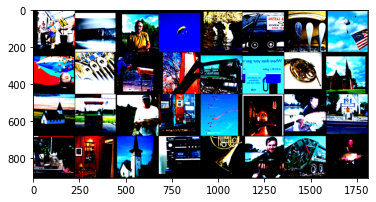

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# define the basic building blocks for ResNet

# option A
class Padding(nn.Module):
    def __init__(self, in_c, out_c):
        super(Padding, self).__init__()
        self.padding = F.pad
        self.pad_dim = (out_c - in_c) / 2

    def forward(self, x):
        x = self.padding(x, (0,0,0,0, self.pad_dim, self.pad_dim), "constant", 0)
        return x

# option Mine
class Concat(nn.Module):
    def __init__(self, in_c, out_c):
        super(Concat, self).__init__()
        
        self.dim_remainder = (out_c - in_c) % in_c
        self.concat_times = (out_c - in_c) // in_c


    def forward(self, x):

        cat_x = [x] * self.concat_times
        cat_x = torch.cat(cat_x, dim=0)
        cat_x = torch.cat((cat_x, x[:self.dim_remainder]), dim=0)

        return cat_x

class BuildingBlock(nn.Module):

    def __init__(self, in_c, out_c, stride=1, option='B'):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.shortcut = nn.Sequential()
        if in_c != out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, out_c)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class Bottleneck(nn.Module):

    def __init__(self, in_c, process_c, stride=1, option='B'):
        super(Bottleneck, self).__init__()

        self.out_c = process_c * 4

        self.conv1 = nn.Conv2d(in_c, process_c, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(process_c)

        self.conv2 = nn.Conv2d(process_c, process_c, kernel_size=3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(process_c)

        self.conv3 = nn.Conv2d(process_c, self.out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(self.out_c)

        self.shortcut = nn.Sequential()
        if in_c != self.out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, self.out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, self.out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(self.out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, self.out_c)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        # slightly changed for CIFAR10
        # in order to have dimension 32x32 --> 16x16
        self.conv_gate = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_gate = nn.BatchNorm2d(64)
        self.maxpool_gate = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn_gate(self.conv_gate(x)))
        x = self.maxpool_gate(x)
        return x

In [ ]:
class ResNet18B(nn.Module):
    def __init__(self):
        super(ResNet18B, self).__init__()

        self.gate = Gate()

        self.conv2_1 = BuildingBlock(64, 64, 1, 'B')
        self.conv2_2 = BuildingBlock(64, 64, 1, 'B')

        self.conv3_1 = BuildingBlock(64, 128, 2, 'B')
        self.conv3_2 = BuildingBlock(128, 128, 1, 'B')

        self.conv4_1 = BuildingBlock(128, 256, 2, 'B')
        self.conv4_2 = BuildingBlock(256, 256, 1, 'B')

        self.conv5_1 = BuildingBlock(256, 512, 2, 'B')
        self.conv5_2 = BuildingBlock(512, 512, 1, 'B')

        self.output = nn.Linear(512, 10)

    def forward(self, x):
        #print("input", x.shape)
        x = self.gate(x)

        #print("1", x.shape)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print("2", x.shape)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        #print("3", x.shape)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        #print("4", x.shape)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        #print("5", x.shape)

        x = F.avg_pool2d(x, 7)
        #print("avgpool", x.shape)

        x = x.view(-1, 512)
        #print("fc", x.shape)

        x = self.output(x)

        return x

In [ ]:
resnet = ResNet18B()
resnet.to(device)

ResNet18B(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv2_2): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNor

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #print(m)
        init.kaiming_normal_(m.weight)
        #torch.nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        #print(m)
        init.kaiming_normal_(m.weight)
        init.zeros_(m.bias)

    # no initialization for BatchNorm2d

In [ ]:
resnet.apply(weights_init)

ResNet18B(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv2_2): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNor

In [ ]:
def train_one_epoch(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = model(image)
        loss = loss_function(pred, label)
    
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : loss {running_loss/length:.4f}')


def eval_one_epoch(model, test_loader, epoch):
    model.eval()
    length = len(test_loader)
    running_acc = 0.0

    for i, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.numpy()

        pred = model(image)
        pred_label = pred.argmax(axis=1).detach().cpu().numpy()
        running_acc += (pred_label==label).mean()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')

    val_acc = running_acc/length

    print(f'epoch {epoch} : acc {val_acc:.4f}')

    return val_acc

In [ ]:
# hyperparameters from paper
# assuming same for pretraining

learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 100

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, 
                            momentum=momentum, weight_decay=weight_decay)

milestones = [60, 80]

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.1
)

# 391 iterations per epoch
# 32k iter = 82 epochs
# 42k iter = 108 epochs
# 64k iter = 164 epochs

In [ ]:
val_acc_list = []

for epoch in range(epochs):
    train_one_epoch(resnet, train_loader, loss_function, optimizer, epoch)
    val_acc_list.append(eval_one_epoch(resnet, test_loader, epoch))
    scheduler.step()

after looking at 128 images, running_loss is 2.5586
after looking at 6528 images, running_loss is 2.3101
after looking at 12928 images, running_loss is 2.2409
after looking at 19328 images, running_loss is 2.1344
after looking at 25728 images, running_loss is 2.0321
after looking at 32128 images, running_loss is 1.9389
epoch 0 : loss 1.8757
after looking at 128 images, running_acc is 0.2500
after looking at 6528 images, running_acc is 0.4804
after looking at 12928 images, running_acc is 0.5263
epoch 0 : acc 0.5317
after looking at 128 images, running_loss is 1.7359
after looking at 6528 images, running_loss is 1.4126
after looking at 12928 images, running_loss is 1.4038
after looking at 19328 images, running_loss is 1.3729
after looking at 25728 images, running_loss is 1.3523
after looking at 32128 images, running_loss is 1.3276
epoch 1 : loss 1.2980
after looking at 128 images, running_acc is 0.4688
after looking at 6528 images, running_acc is 0.4988
after looking at 12928 images, run

In [ ]:
val_acc_list

[0.5316613433991483,
 0.5705937862950058,
 0.6959688346883469,
 0.6550280681378242,
 0.7446283391405342,
 0.710087591947348,
 0.7533875338753387,
 0.6896293070073558,
 0.7602230933023616,
 0.7674941927990708,
 0.7951751838946961,
 0.7632718737901665,
 0.7793384630274874,
 0.8179321525358111,
 0.8184281842818428,
 0.8035835269066977,
 0.8066323073945025,
 0.7981029810298104,
 0.788835656213705,
 0.8395276809910956,
 0.8275745257452575,
 0.8246588269454123,
 0.8385235191637631,
 0.8010428765001936,
 0.8350754936120789,
 0.8439798683701123,
 0.8273446573751452,
 0.8278285907859079,
 0.8404229578010066,
 0.8446089818041037,
 0.8545417150600078,
 0.832171893147503,
 0.8072856174990322,
 0.8461333720480062,
 0.8622725512969416,
 0.8343012001548588,
 0.8621636662795199,
 0.8499443476577623,
 0.8465084204413472,
 0.8507186411149826,
 0.8460244870305845,
 0.862006387921022,
 0.8772744870305845,
 0.8716850561362756,
 0.859102787456446,
 0.8599738675958187,
 0.850984804490902,
 0.8702816492450639

In [ ]:
torch.randn([128, 512, 2, 2])

tensor([[[[-7.6783e-01,  2.0151e+00],
          [-1.1618e+00,  1.3648e-01]],

         [[ 4.1067e-02,  8.9933e-01],
          [ 9.6955e-01, -3.3103e-01]],

         [[-3.7222e-01, -6.4606e-01],
          [-1.9535e+00,  1.2130e+00]],

         ...,

         [[ 7.4823e-01,  1.9417e+00],
          [ 1.4750e+00, -7.0857e-01]],

         [[ 2.2575e+00,  5.8739e-01],
          [-5.2577e-01,  7.2165e-02]],

         [[-1.6352e+00,  3.3929e-01],
          [-2.0658e+00,  1.0441e+00]]],


        [[[-5.2425e-01, -8.7652e-01],
          [-1.4459e+00, -5.6935e-02]],

         [[-9.0398e-01,  9.4186e-01],
          [-8.1441e-01, -1.5671e-01]],

         [[ 6.2117e-01, -2.5500e-01],
          [-7.9258e-01,  2.1846e-01]],

         ...,

         [[-8.8737e-01,  1.1365e+00],
          [-2.2221e-01, -1.7795e+00]],

         [[ 1.4746e+00, -5.1170e-01],
          [ 2.1508e-02, -1.2735e-01]],

         [[ 5.3882e-01, -8.4113e-01],
          [-1.0104e+00,  3.3064e-01]]],


        [[[ 3.0526e-01,  3.140

In [ ]:
torch.cat(cat, dim=0).shape

NameError: ignored

In [ ]:
torch.cat((t4d, t4d), dim=0)

In [ ]:
F.pad(t4d, (1,1,1,1,4,4))

In [ ]:
F.avg_pool2d(torch.randn([128, 512, 2, 2]), 2)

In [ ]:
6